
GENERATIVE ADVERSARIAL NETWORKS (GANs)
======================================

Project: Handwritten Digit Generation using GANs

Author: Nishu Kumari Singh

Dataset: MNIST (60,000 handwritten digits, 28x28 pixels)
Models: Vanilla GAN and DCGAN

Objectives:
- Implement Generator and Discriminator networks from scratch
- Train adversarial networks to generate realistic handwritten digits
- Compare fully connected (Vanilla GAN) vs convolutional (DCGAN) architectures
- Demonstrate understanding of adversarial training dynamics

Components:
1. Vanilla GAN: Fully connected layers
2. DCGAN: Deep Convolutional GAN with upsampling and stride convolutions
3. Loss visualization and training progression analysis
4. Model comparison and evaluation

Key Concepts:
- Adversarial training
- Generator architecture (noise → image)
- Discriminator architecture (image → real/fake classification)
- Training stability techniques (batch normalization, dropout, learning rate tuning)

Runtime: Approximately 30-40 minutes on GPU


In [1]:
# Block 1: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt
import os

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Create directories
os.makedirs('generated_images', exist_ok=True)
os.makedirs('saved_models', exist_ok=True)
print("Directories created.")

Device: cuda
Directories created.


In [2]:
# Block 2: Load MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

print(f"Dataset size: {len(train_dataset)}")
print(f"Number of batches: {len(train_loader)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Value range after normalization: [-1, 1]")

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.93MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.65MB/s]

Dataset size: 60000
Number of batches: 469
Image shape: torch.Size([1, 28, 28])
Value range after normalization: [-1, 1]


Displaying 64 real MNIST digits


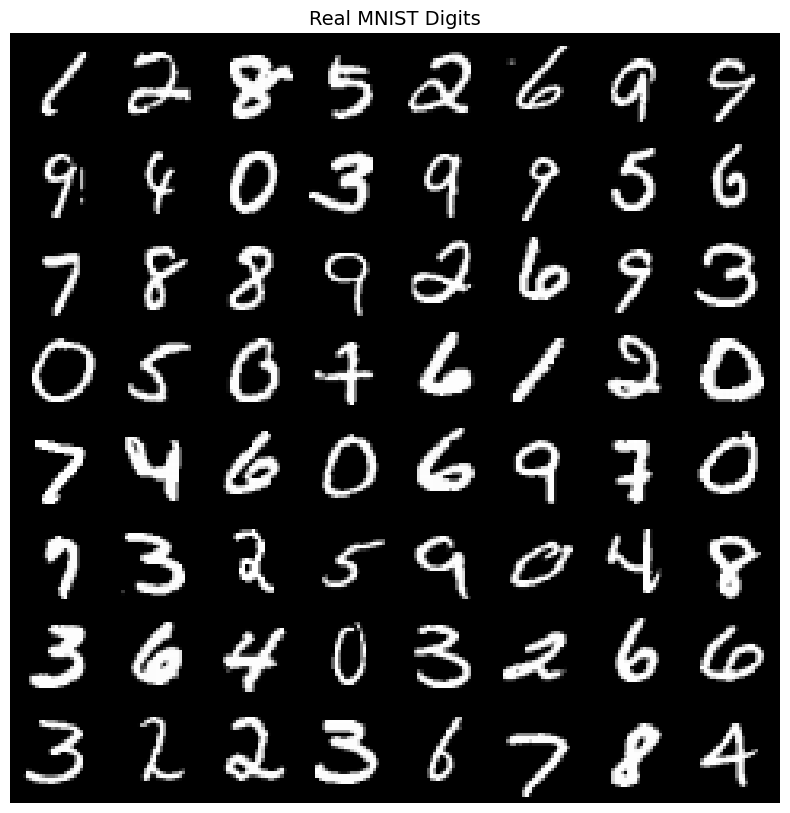

In [3]:
# Block 3: Visualize Real MNIST Digits
def show_images(images, nrow=8, title="Images"):
    """
    Display grid of images.
    """
    grid = make_grid(images, nrow=nrow, normalize=True, value_range=(-1, 1))
    grid = grid.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray')
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

# Get batch of real images
real_batch = next(iter(train_loader))[0][:64]

print(f"Displaying 64 real MNIST digits")
show_images(real_batch, nrow=8, title="Real MNIST Digits")

In [4]:
# Block 4: Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

# Initialize generator
latent_dim = 100
generator = Generator(latent_dim).to(device)

# Test generator
test_noise = torch.randn(8, latent_dim).to(device)
test_images = generator(test_noise)

print(f"Generator initialized")
print(f"Input: Random noise vector of size {latent_dim}")
print(f"Output: Image of shape {test_images.shape}")
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")

Generator initialized
Input: Random noise vector of size 100
Output: Image of shape torch.Size([8, 1, 28, 28])
Generator parameters: 1,489,936


In [5]:
# Block 5: Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Initialize discriminator
discriminator = Discriminator().to(device)

# Test discriminator
test_output = discriminator(test_images)

print(f"Discriminator initialized")
print(f"Input: Image of shape (batch, 1, 28, 28)")
print(f"Output: Probability score {test_output.shape}")
print(f"Output range: [0, 1] where 1=real, 0=fake")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

Discriminator initialized
Input: Image of shape (batch, 1, 28, 28)
Output: Probability score torch.Size([8, 1])
Output range: [0, 1] where 1=real, 0=fake
Discriminator parameters: 533,505


In [6]:
# Block 6: Loss Function and Optimizers
adversarial_loss = nn.BCELoss()

learning_rate = 0.0002
beta1 = 0.5

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

print("Training setup:")
print(f"Loss function: Binary Cross Entropy")
print(f"Learning rate: {learning_rate}")
print(f"Beta1: {beta1}")
print(f"Generator optimizer: Adam")
print(f"Discriminator optimizer: Adam")
print("\nBoth networks have separate optimizers for adversarial training.")

Training setup:
Loss function: Binary Cross Entropy
Learning rate: 0.0002
Beta1: 0.5
Generator optimizer: Adam
Discriminator optimizer: Adam

Both networks have separate optimizers for adversarial training.


In [7]:
# Block 7: Training Function
def train_gan_epoch(generator, discriminator, dataloader, optimizer_G, optimizer_D,
                    adversarial_loss, device, latent_dim):
    """
    Trains GAN for one epoch.
    """
    generator.train()
    discriminator.train()

    epoch_d_loss = 0
    epoch_g_loss = 0

    for i, (real_imgs, _) in enumerate(dataloader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Loss on real images
        real_output = discriminator(real_imgs)
        d_loss_real = adversarial_loss(real_output, real_labels)

        # Generate fake images
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)

        # Loss on fake images
        fake_output = discriminator(fake_imgs.detach())
        d_loss_fake = adversarial_loss(fake_output, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generator wants discriminator to think fakes are real
        fake_output = discriminator(fake_imgs)
        g_loss = adversarial_loss(fake_output, real_labels)

        g_loss.backward()
        optimizer_G.step()

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

    avg_d_loss = epoch_d_loss / len(dataloader)
    avg_g_loss = epoch_g_loss / len(dataloader)

    return avg_d_loss, avg_g_loss

print("Training function defined.")

Training function defined.


In [8]:
# Block 8: Training Loop
num_epochs = 50

d_losses = []
g_losses = []

print(f"Starting GAN training for {num_epochs} epochs...")
print(f"Batches per epoch: {len(train_loader)}")
print()

# Fixed noise for consistent generation visualization
fixed_noise = torch.randn(64, latent_dim).to(device)

for epoch in range(num_epochs):
    d_loss, g_loss = train_gan_epoch(
        generator, discriminator, train_loader,
        optimizer_G, optimizer_D, adversarial_loss,
        device, latent_dim
    )

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

        # Save generated images
        with torch.no_grad():
            fake_imgs = generator(fixed_noise)
            save_image(fake_imgs, f'generated_images/epoch_{epoch+1}.png',
                      nrow=8, normalize=True, value_range=(-1, 1))

print("\nTraining completed.")

Starting GAN training for 50 epochs...
Batches per epoch: 469

Epoch [5/50] | D Loss: 1.2855 | G Loss: 0.8388
Epoch [10/50] | D Loss: 1.3479 | G Loss: 0.7566
Epoch [15/50] | D Loss: 1.3603 | G Loss: 0.7471
Epoch [20/50] | D Loss: 1.3641 | G Loss: 0.7430
Epoch [25/50] | D Loss: 1.3664 | G Loss: 0.7377
Epoch [30/50] | D Loss: 1.3682 | G Loss: 0.7339
Epoch [35/50] | D Loss: 1.3700 | G Loss: 0.7318
Epoch [40/50] | D Loss: 1.3710 | G Loss: 0.7299
Epoch [45/50] | D Loss: 1.3698 | G Loss: 0.7308
Epoch [50/50] | D Loss: 1.3720 | G Loss: 0.7279

Training completed.


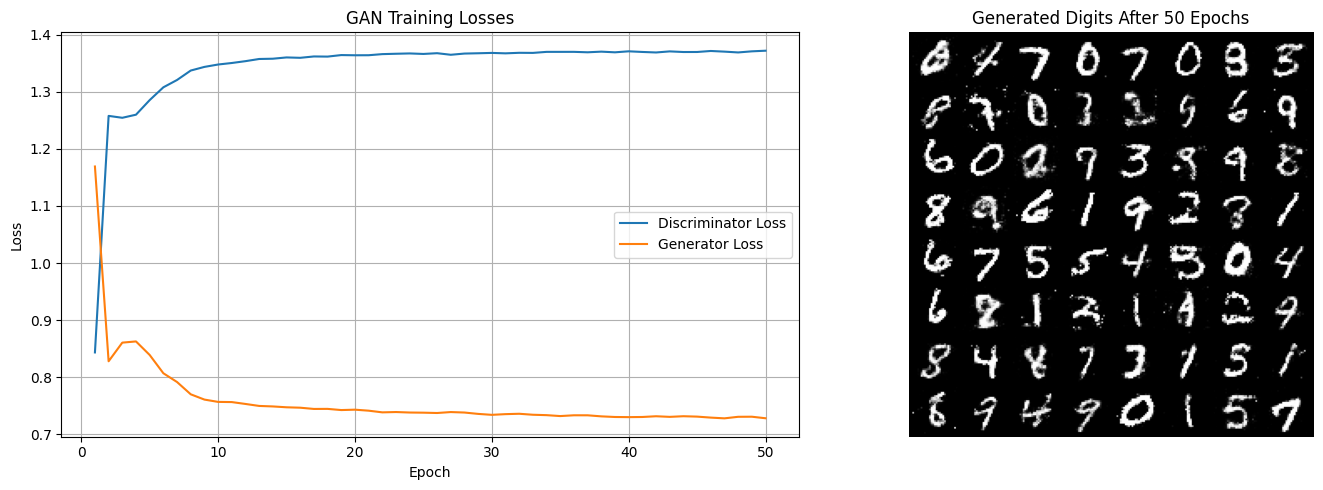

Training Summary:
Initial D Loss: 0.8433 | Final D Loss: 1.3720
Initial G Loss: 1.1691 | Final G Loss: 0.7279

Loss stabilization indicates balanced adversarial training.


In [9]:
# Block 9: Visualize Training Results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
epochs_range = range(1, num_epochs + 1)
ax1.plot(epochs_range, d_losses, label='Discriminator Loss')
ax1.plot(epochs_range, g_losses, label='Generator Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('GAN Training Losses')
ax1.legend()
ax1.grid(True)

# Display final generated images
with torch.no_grad():
    final_fake = generator(fixed_noise)

final_grid = make_grid(final_fake, nrow=8, normalize=True, value_range=(-1, 1))
final_grid = final_grid.permute(1, 2, 0).cpu().numpy()

ax2.imshow(final_grid, cmap='gray')
ax2.set_title('Generated Digits After 50 Epochs')
ax2.axis('off')

plt.tight_layout()
plt.show()

print("Training Summary:")
print(f"Initial D Loss: {d_losses[0]:.4f} | Final D Loss: {d_losses[-1]:.4f}")
print(f"Initial G Loss: {g_losses[0]:.4f} | Final G Loss: {g_losses[-1]:.4f}")
print(f"\nLoss stabilization indicates balanced adversarial training.")

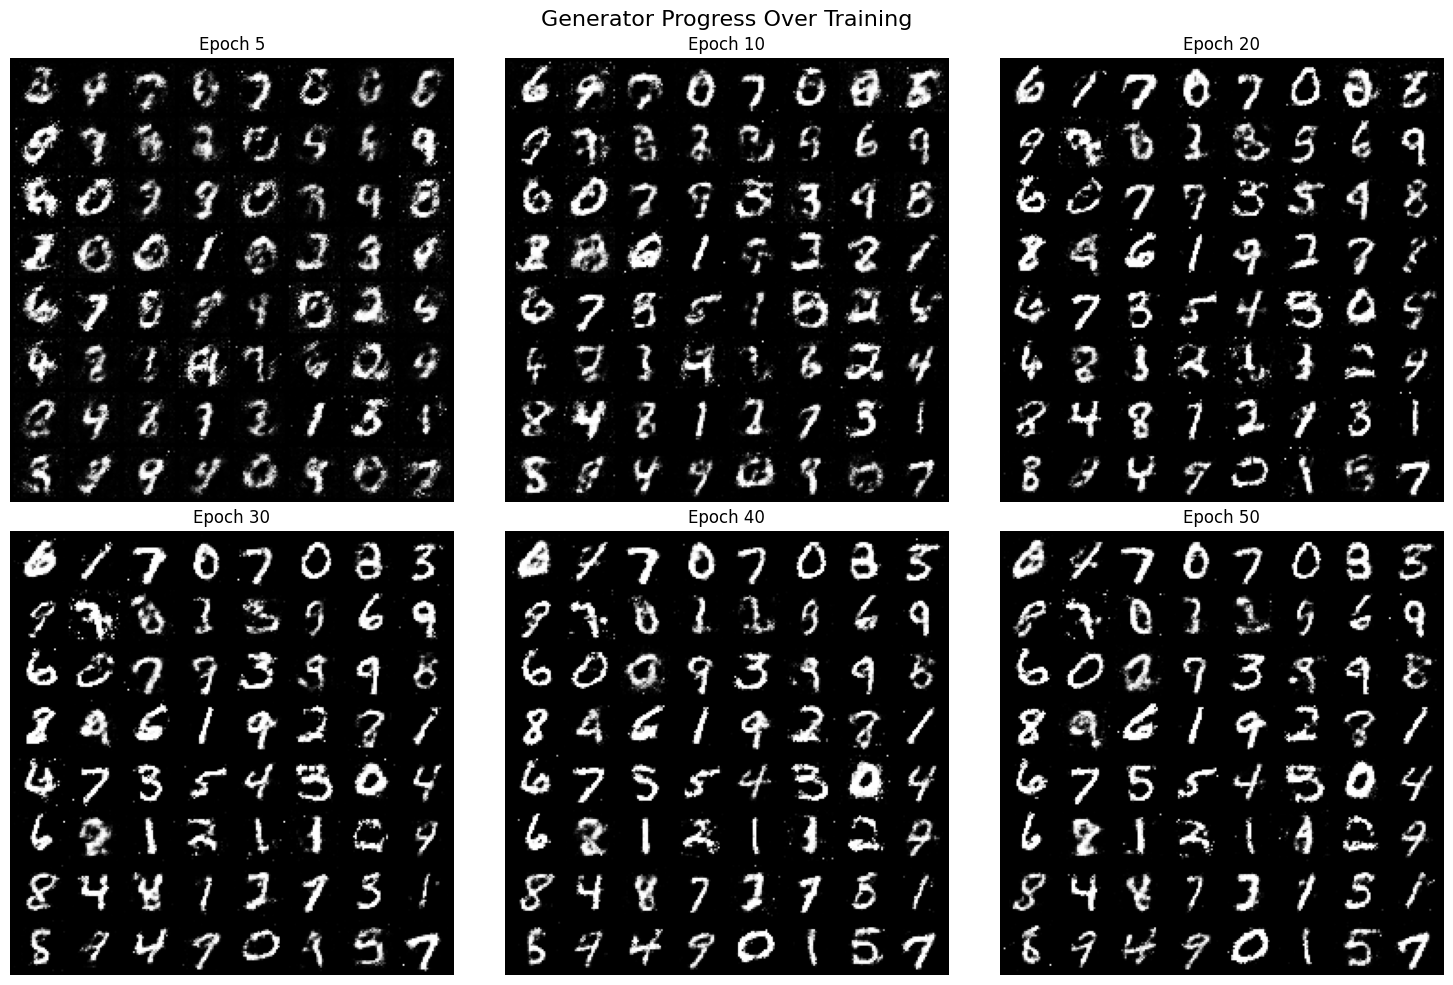

Image quality progression:
Early epochs: Noisy, unclear patterns
Mid epochs: Recognizable digit shapes emerging
Late epochs: Clear, distinct digits


In [16]:
# Block 10: Compare Generation Progress
from PIL import Image

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

epochs_to_show = [5, 10, 20, 30, 40, 50]

for idx, epoch in enumerate(epochs_to_show):
    row = idx // 3
    col = idx % 3

    img_path = f'generated_images/epoch_{epoch}.png'
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'Epoch {epoch}')
        axes[row, col].axis('off')

plt.suptitle('Generator Progress Over Training', fontsize=16)
plt.tight_layout()
plt.show()

print("Image quality progression:")
print("Early epochs: Noisy, unclear patterns")
print("Mid epochs: Recognizable digit shapes emerging")
print("Late epochs: Clear, distinct digits")

In [17]:
# Block 11: DCGAN Generator
class DCGANGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()

        self.init_size = 7
        self.fc = nn.Linear(latent_dim, 128 * self.init_size * self.init_size)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Initialize DCGAN generator
dcgan_generator = DCGANGenerator(latent_dim).to(device)

# Test
test_noise = torch.randn(8, latent_dim).to(device)
test_output = dcgan_generator(test_noise)

print(f"DCGAN Generator initialized")
print(f"Architecture: Convolutional layers with upsampling")
print(f"Output shape: {test_output.shape}")
print(f"Parameters: {sum(p.numel() for p in dcgan_generator.parameters()):,}")

DCGAN Generator initialized
Architecture: Convolutional layers with upsampling
Output shape: torch.Size([8, 1, 28, 28])
Parameters: 856,065


In [18]:
# Block 12: DCGAN Discriminator
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.25),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.25),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.25),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.25)
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 2 * 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.fc(out)
        return validity

# Initialize DCGAN discriminator
dcgan_discriminator = DCGANDiscriminator().to(device)

# Test
test_output = dcgan_discriminator(test_output)

print(f"DCGAN Discriminator initialized")
print(f"Architecture: Convolutional layers with stride")
print(f"Output shape: {test_output.shape}")
print(f"Parameters: {sum(p.numel() for p in dcgan_discriminator.parameters()):,}")

DCGAN Discriminator initialized
Architecture: Convolutional layers with stride
Output shape: torch.Size([8, 1])
Parameters: 98,113


In [19]:
# Block 13: Setup DCGAN Training
dcgan_optimizer_G = optim.Adam(dcgan_generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
dcgan_optimizer_D = optim.Adam(dcgan_discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

print("DCGAN training setup:")
print(f"Generator optimizer: Adam (lr={learning_rate})")
print(f"Discriminator optimizer: Adam (lr={learning_rate})")
print("Ready to train DCGAN.")

DCGAN training setup:
Generator optimizer: Adam (lr=0.0002)
Discriminator optimizer: Adam (lr=0.0002)
Ready to train DCGAN.


In [20]:
# Block 14: Train DCGAN
dcgan_epochs = 30

dcgan_d_losses = []
dcgan_g_losses = []

print(f"Starting DCGAN training for {dcgan_epochs} epochs...")
print()

# Fixed noise for visualization
dcgan_fixed_noise = torch.randn(64, latent_dim).to(device)

for epoch in range(dcgan_epochs):
    d_loss, g_loss = train_gan_epoch(
        dcgan_generator, dcgan_discriminator, train_loader,
        dcgan_optimizer_G, dcgan_optimizer_D, adversarial_loss,
        device, latent_dim
    )

    dcgan_d_losses.append(d_loss)
    dcgan_g_losses.append(g_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{dcgan_epochs}] | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

        with torch.no_grad():
            fake_imgs = dcgan_generator(dcgan_fixed_noise)
            save_image(fake_imgs, f'generated_images/dcgan_epoch_{epoch+1}.png',
                      nrow=8, normalize=True, value_range=(-1, 1))

print("\nDCGAN training completed.")

Starting DCGAN training for 30 epochs...

Epoch [5/30] | D Loss: 1.1237 | G Loss: 1.0203
Epoch [10/30] | D Loss: 1.0395 | G Loss: 1.1964
Epoch [15/30] | D Loss: 1.0234 | G Loss: 1.2553
Epoch [20/30] | D Loss: 1.0265 | G Loss: 1.3052
Epoch [25/30] | D Loss: 0.9975 | G Loss: 1.3078
Epoch [30/30] | D Loss: 0.9903 | G Loss: 1.3385

DCGAN training completed.


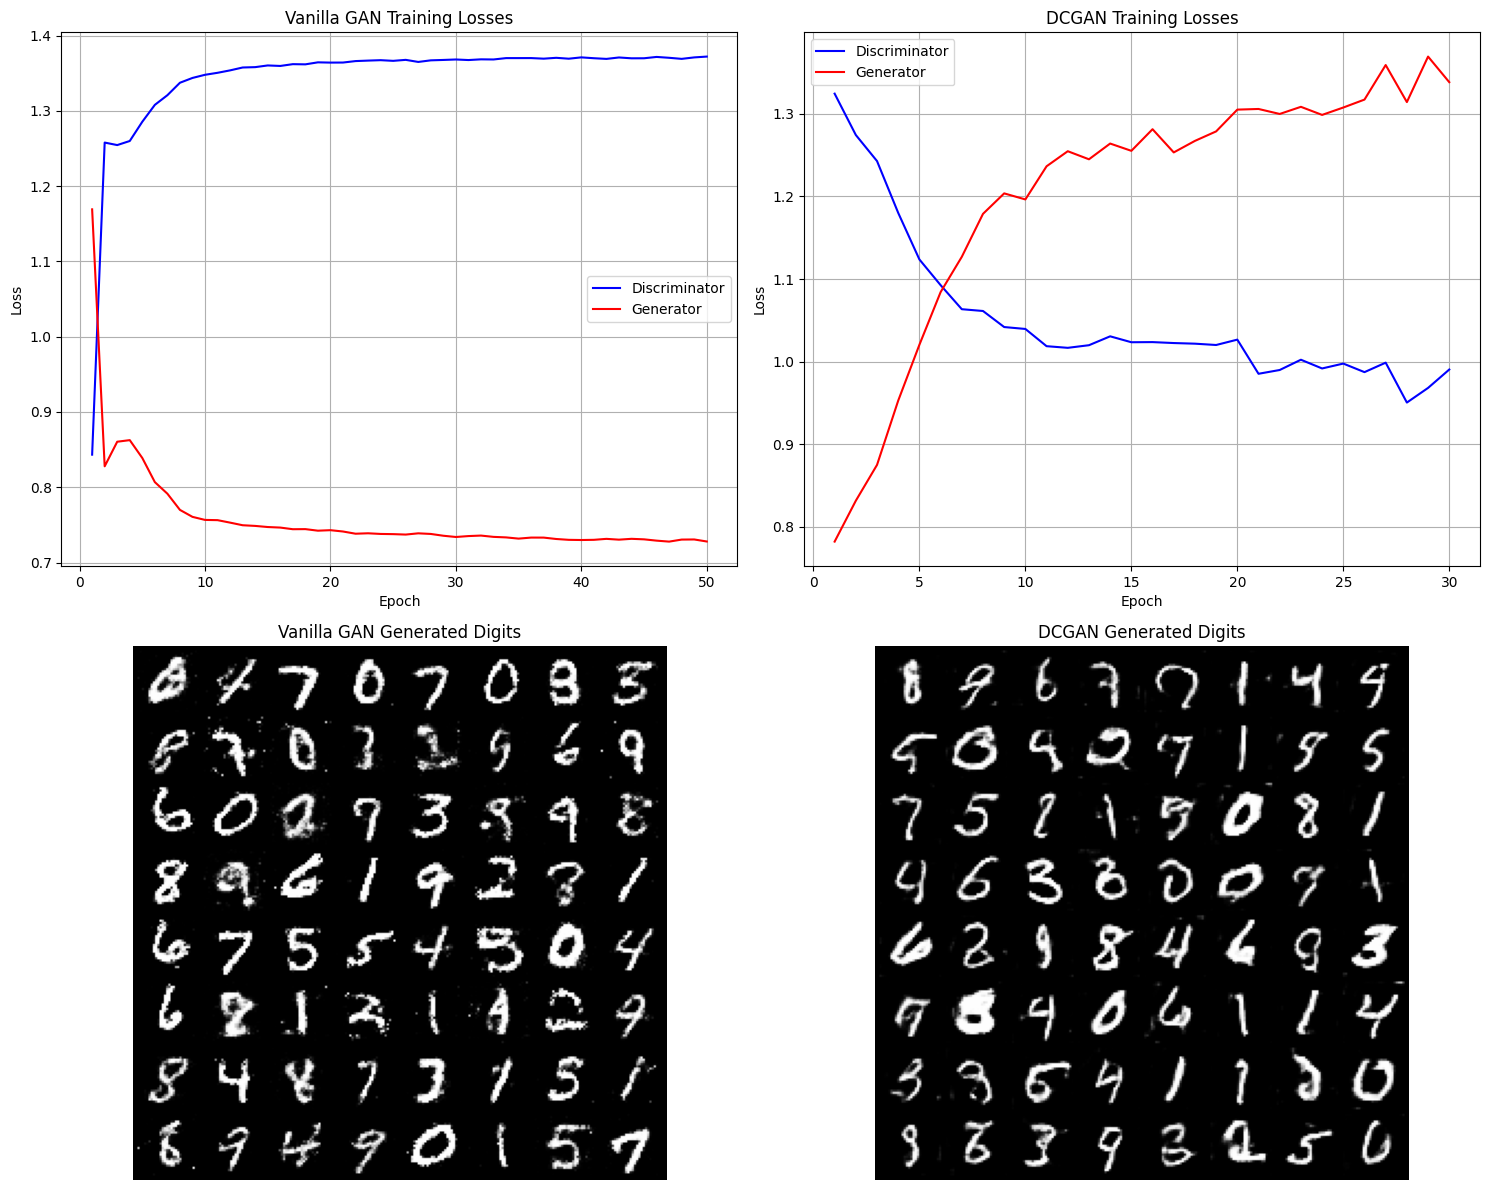

Comparison Results:

Vanilla GAN:
  Architecture: Fully connected layers
  Training epochs: 50
  Final D Loss: 1.3720
  Final G Loss: 0.7279
  Parameters: 1,489,936

DCGAN:
  Architecture: Convolutional layers
  Training epochs: 30
  Final D Loss: 0.9903
  Final G Loss: 1.3385
  Parameters: 856,065

Key Differences:
  DCGAN uses spatial structure (convolutions)
  DCGAN typically produces sharper images
  DCGAN converges faster (30 vs 50 epochs)


In [21]:
# Block 15: Compare Vanilla GAN vs DCGAN
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot losses
axes[0, 0].plot(range(1, num_epochs + 1), d_losses, label='Discriminator', color='blue')
axes[0, 0].plot(range(1, num_epochs + 1), g_losses, label='Generator', color='red')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Vanilla GAN Training Losses')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(range(1, dcgan_epochs + 1), dcgan_d_losses, label='Discriminator', color='blue')
axes[0, 1].plot(range(1, dcgan_epochs + 1), dcgan_g_losses, label='Generator', color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('DCGAN Training Losses')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Generate and display images from both models
with torch.no_grad():
    vanilla_samples = generator(fixed_noise)
    dcgan_samples = dcgan_generator(dcgan_fixed_noise)

vanilla_grid = make_grid(vanilla_samples[:64], nrow=8, normalize=True, value_range=(-1, 1))
vanilla_grid = vanilla_grid.permute(1, 2, 0).cpu().numpy()

dcgan_grid = make_grid(dcgan_samples[:64], nrow=8, normalize=True, value_range=(-1, 1))
dcgan_grid = dcgan_grid.permute(1, 2, 0).cpu().numpy()

axes[1, 0].imshow(vanilla_grid, cmap='gray')
axes[1, 0].set_title('Vanilla GAN Generated Digits')
axes[1, 0].axis('off')

axes[1, 1].imshow(dcgan_grid, cmap='gray')
axes[1, 1].set_title('DCGAN Generated Digits')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("Comparison Results:")
print("=" * 60)
print("\nVanilla GAN:")
print(f"  Architecture: Fully connected layers")
print(f"  Training epochs: {num_epochs}")
print(f"  Final D Loss: {d_losses[-1]:.4f}")
print(f"  Final G Loss: {g_losses[-1]:.4f}")
print(f"  Parameters: {sum(p.numel() for p in generator.parameters()):,}")

print("\nDCGAN:")
print(f"  Architecture: Convolutional layers")
print(f"  Training epochs: {dcgan_epochs}")
print(f"  Final D Loss: {dcgan_d_losses[-1]:.4f}")
print(f"  Final G Loss: {dcgan_g_losses[-1]:.4f}")
print(f"  Parameters: {sum(p.numel() for p in dcgan_generator.parameters()):,}")

print("\nKey Differences:")
print("  DCGAN uses spatial structure (convolutions)")
print("  DCGAN typically produces sharper images")
print("  DCGAN converges faster (30 vs 50 epochs)")
print("=" * 60)

In [22]:
# Block 16: Save Models and Project Summary
# Save all models
torch.save(generator.state_dict(), 'saved_models/vanilla_gan_generator.pth')
torch.save(discriminator.state_dict(), 'saved_models/vanilla_gan_discriminator.pth')
torch.save(dcgan_generator.state_dict(), 'saved_models/dcgan_generator.pth')
torch.save(dcgan_discriminator.state_dict(), 'saved_models/dcgan_discriminator.pth')

print("Models saved successfully")
print()

print("=" * 70)
print("GAN PROJECT SUMMARY")
print("=" * 70)

print("\nDataset:")
print(f"  MNIST: {len(train_dataset)} training images")
print(f"  Image size: 28x28 pixels")
print(f"  Classes: 10 digits (0-9)")

print("\nImplemented Architectures:")
print("  1. Vanilla GAN (Fully Connected)")
print("  2. DCGAN (Convolutional)")

print("\nVanilla GAN:")
print(f"  Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"  Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")
print(f"  Training: {num_epochs} epochs")
print(f"  Final losses - D: {d_losses[-1]:.4f}, G: {g_losses[-1]:.4f}")

print("\nDCGAN:")
print(f"  Generator parameters: {sum(p.numel() for p in dcgan_generator.parameters()):,}")
print(f"  Discriminator parameters: {sum(p.numel() for p in dcgan_discriminator.parameters()):,}")
print(f"  Training: {dcgan_epochs} epochs")
print(f"  Final losses - D: {dcgan_d_losses[-1]:.4f}, G: {dcgan_g_losses[-1]:.4f}")

print("\nKey Achievements:")
print("  ✓ Generator: Transforms random noise into realistic digits")
print("  ✓ Discriminator: Distinguishes real from generated images")
print("  ✓ Adversarial training: Both networks improve simultaneously")
print("  ✓ Loss stabilization: Balanced training achieved")
print("  ✓ Architecture comparison: Fully connected vs convolutional")
print("  ✓ Visual progression: Clear improvement over epochs")

print("\nTechnical Concepts Demonstrated:")
print("  • Adversarial training dynamics")
print("  • Generator architecture (noise to image)")
print("  • Discriminator architecture (image classification)")
print("  • Loss functions (Binary Cross Entropy)")
print("  • Training stability techniques")
print("  • Convolutional vs fully connected layers")
print("  • Batch normalization and dropout")

print("\n" + "=" * 70)
print("PROJECT COMPLETED SUCCESSFULLY")
print("=" * 70)

Models saved successfully

GAN PROJECT SUMMARY

Dataset:
  MNIST: 60000 training images
  Image size: 28x28 pixels
  Classes: 10 digits (0-9)

Implemented Architectures:
  1. Vanilla GAN (Fully Connected)
  2. DCGAN (Convolutional)

Vanilla GAN:
  Generator parameters: 1,489,936
  Discriminator parameters: 533,505
  Training: 50 epochs
  Final losses - D: 1.3720, G: 0.7279

DCGAN:
  Generator parameters: 856,065
  Discriminator parameters: 98,113
  Training: 30 epochs
  Final losses - D: 0.9903, G: 1.3385

Key Achievements:
  ✓ Generator: Transforms random noise into realistic digits
  ✓ Discriminator: Distinguishes real from generated images
  ✓ Adversarial training: Both networks improve simultaneously
  ✓ Loss stabilization: Balanced training achieved
  ✓ Architecture comparison: Fully connected vs convolutional
  ✓ Visual progression: Clear improvement over epochs

Technical Concepts Demonstrated:
  • Adversarial training dynamics
  • Generator architecture (noise to image)
  • Dis